# Análisis de datos con Julia

Tutorial práctico (≈ 3 horas) para aprender manejo de datos en Julia. Este notebook está pensado para ejecutarse desde Google Colab (verificar que el runtime kernel sea Julia), donde todos los paquetes ya vienen preinstalados.

Contenido:
1. Cargar y explorar datos
2. Limpieza y transformación
3. Agrupamiento y resumen
4. Visualización
5. Joins y múltiples tablas

---

## 1. Revision del entorno

Verificamos los paquetes que estan dispopnibles en Google Colab. Si necesitamos instalar un paquete no disponible, utlizamos la instruccion `] add NombrePaquete`.

In [3]:
# Verificar la version de Julia
println("Julia: ", VERSION)

Julia: 1.11.6


In [ ]:
# Verificar paquetes disponibles
] st

In [ ]:
# Instalar paquetes
] add CairoMakie

# Importar paquetes
using DataFrames, CairoMakie


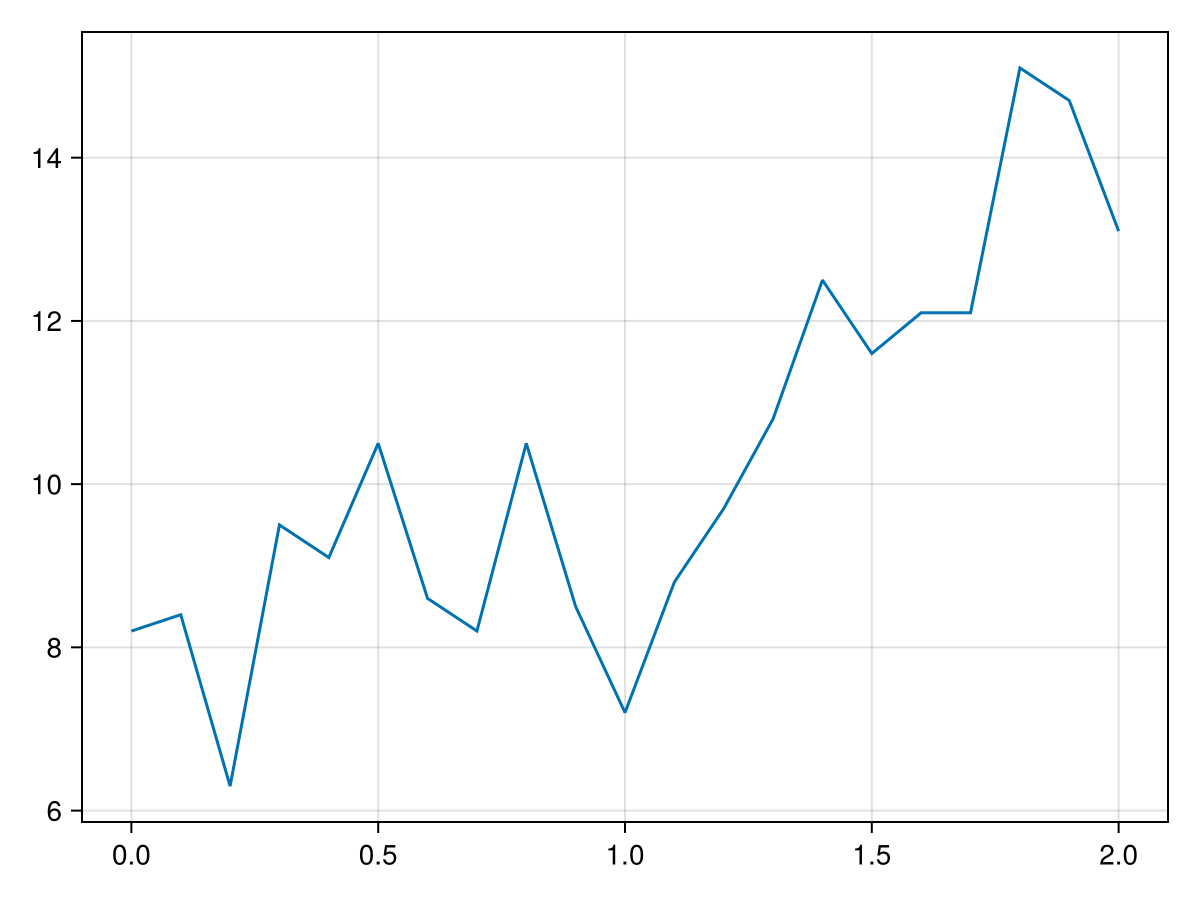

In [12]:
seconds = 0:0.1:2
measurements = [8.2, 8.4, 6.3, 9.5, 9.1, 10.5, 8.6, 8.2, 10.5, 8.5, 7.2,
        8.8, 9.7, 10.8, 12.5, 11.6, 12.1, 12.1, 15.1, 14.7, 13.1]
lines(seconds, measurements)

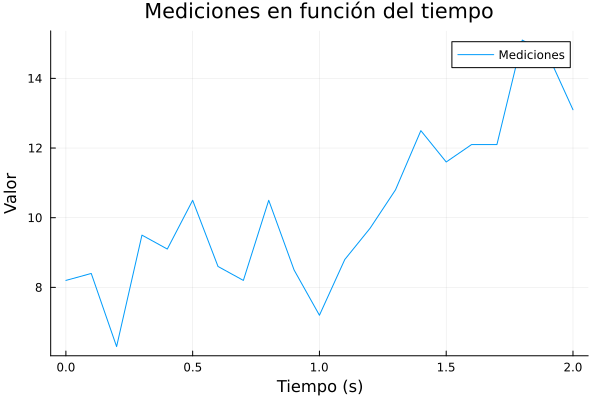

In [16]:
using Plots
Plots.plot(seconds, measurements, label="Mediciones", xlabel="Tiempo (s)", ylabel="Valor", title="Mediciones en función del tiempo", legend=:topright)

In [ ]:
# Paquetes principales (no ejecutes Pkg.add aquí si ya tienes los paquetes en el entorno).
using DataFrames, CSV, CategoricalArrays, Statistics, Dates, Downloads, Random
# Para gráficas opcionalmente
# using StatsPlots

println("Julia: ", VERSION)
println("Paquetes: DataFrames, CSV, CategoricalArrays, Statistics, Dates, Downloads")

## 2) Cargar y explorar datos públicos (45 min)

Descargaremos dos datasets públicos: Titanic (fila por pasajero) y Gapminder (indicadores por país/año).

In [ ]:
# URLs de datasets públicos (raw GitHub)
titanic_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
gapminder_url = "https://raw.githubusercontent.com/resbaz/r-novice-gapminder-files/master/data/gapminder-FiveYearData.csv"

# Descargar a archivos temporales y leerlos
titanic_file = Downloads.download(titanic_url)
gapminder_file = Downloads.download(gapminder_url)

df_titanic = CSV.read(titanic_file, DataFrame)
df_gap = CSV.read(gapminder_file, DataFrame)

println("Titanic: rows=", nrow(df_titanic), " cols=", ncol(df_titanic))
println("Gapminder: rows=", nrow(df_gap), " cols=", ncol(df_gap))

first(df_titanic, 6), first(df_gap, 6)

Exploración rápida: tipos de columnas, conteo de valores faltantes y vista general con `describe`.

In [ ]:
# Estructura y tipos
println("Titanic columns:")
show(names(df_titanic))
println()
println(map(col->eltype(df_titanic[!,col]), names(df_titanic)))

# Conteo de missings por columna
miss_tit = Dict(col => count(ismissing, df_titanic[!, col]) for col in names(df_titanic))
miss_gap = Dict(col => count(ismissing, df_gap[!, col]) for col in names(df_gap))
println("Missings Titanic:", miss_tit)
println("Missings Gapminder:", miss_gap)

# Resumen estadístico de variables numéricas
describe(df_titanic)


## 3) Limpieza y transformación (60 min)

Mostraremos técnicas comunes: tratamiento de missings, conversión de tipos, creación de columnas derivadas y filtros.

In [ ]:
# Copiamos para no mutar el original durante la práctica
df = copy(df_titanic)

# 1) Convertir algunas columnas a categóricas
df.Sex = CategoricalArray(df.Sex)
df.Pclass = CategoricalArray(string.(df.Pclass))  # tratar clase como categoría

# 2) Missings: 'Age' tiene missings; imputaremos con la mediana por Pclass+Sex
using Statistics
median_age = median(skipmissing(df.Age))
# imputación simple global (ejemplo)
df.Age = coalesce.(df.Age, median_age),
# Nota: mostramos alternativa por grupo (más abajo)

# 3) Crear columnas derivadas: edad agrupada y indicador de viajero solo
df.age_group = cut(df.Age, 0:10:80; labels=false)
df.is_alone = (df.SibSp .+ df.Parch) .== 0

# 4) Filtrar y ordenar ejemplos
adultos = filter(:Age => x -> x .>= 18, df)
ordenados = sort(df, [:Pclass, :Age], rev=(false,true))

first(adultos,6)


## 4) Agrupamiento y resumen (45 min)

Uso de `groupby` y `combine` para calcular tasas y resúmenes por grupo.

In [ ]:
# Tasa de supervivencia por sexo y clase
g = groupby(df, [:Sex, :Pclass])
res = combine(g, nrow => :n, :Survived => x -> mean(x) => :survival_rate, :Age => mean => :mean_age)
res

# Resumen por edad agrupada
g2 = groupby(df, :age_group)
res2 = combine(g2, nrow => :n, :Survived => x-> mean(x) => :survival_rate)
first(res2, 10)

## 5) Visualización básica (30 min)

Ejemplos rápidos con `StatsPlots` (si está disponible). En Colab puede que necesites un backend gráfico compatible con IJulia.

In [ ]:
# Gráficos: supervivencia por edad y clase (si StatsPlots está disponible)
try
    using StatsPlots
    @df df scatter(:Age, :Survived, group=:Pclass, ms=3, title="Survived vs Age (por Pclass)")
    @df df boxplot(:Pclass, :Age, title="Distribución de edad por clase")
catch e
    println("StatsPlots no disponible en este kernel: ", e)
end

## 6) Joins y trabajo con múltiples tablas (20 min)

Mostraremos un ejemplo simple de join: mapear códigos de embarque a nombres de puerto.

In [ ]:
# Creamos una tabla auxiliar para 'Embarked'
ports = DataFrame(Embarked=["C","Q","S"], port_name=["Cherbourg", "Queenstown", "Southampton"])
# 'Embarked' en el dataset original es una columna de caracteres; normalizamos y hacemos join
df2 = copy(df)
df2.Embarked = CategoricalArray(string.(df2.Embarked))
joined = leftjoin(df2, ports, on = :Embarked)
first(joined,8)

## 7) Ejercicios guiados (25 min)

Prueba primero, luego mira las soluciones en la celda siguiente.

Ejercicios:
1. Calcular el porcentaje de supervivientes por `Pclass` y `Sex` (ordenar resultados).
2. Crear una columna `fare_per_person` approximando `Fare / (SibSp + Parch + 1)`, y mostrar estadísticos por `Pclass`.
3. Usando `df_gap`, calcular el crecimiento promedio del GDP per capita (gdpPercap) por continente entre 1952 y 2007.
4. Guardar un subconjunto filtrado (por ejemplo pasajeros sobrevivientes de clase 1) a CSV en un archivo temporal y volver a leerlo.

In [ ]:
# Soluciones propuestas (ejemplos rápidos)
# Ej 1: supervivencia por Pclass y Sex
s = combine(groupby(df, [:Pclass, :Sex]), nrow => :n, :Survived => x -> mean(x) * 100 => :pct_survived)
sort!(s, [:Pclass, :Sex])
println(s)

# Ej 2: fare per person
df.fare_per_person = df.Fare ./ (df.SibSp .+ df.Parch .+ 1)
combine(groupby(df, :Pclass), :fare_per_person => mean => :mean_fare_pp, :fare_per_person => std => :sd_fare_pp)

# Ej 3: gapminder crecimiento promedio gdpPercap por continente
g = groupby(df_gap, :continent)
resg = combine(g, :gdpPercap => x -> (last(x) - first(x)) / length(x) => :avg_growth),
println(first(resg, 10))

# Ej 4: guardar y leer CSV temporal
tmp = tempname() * "_survivors.csv"
CSV.write(tmp, filter(:Survived => ==(1) .&& :Pclass => ==("1"), df))
df_check = CSV.read(tmp, DataFrame)
println("Escrito y leído: rows=", nrow(df_check))

## 8) Recursos y próximos pasos

- Documentación de DataFrames.jl: https://dataframes.juliadata.org
- DataFramesMeta.jl para macros estilo dplyr
- Tables.jl para interoperabilidad con otros paquetes
- JuliaAcademy y libros recomendados

Nota: en Google Colab asegúrate de usar un kernel de Julia (IJulia). Si no tienes los paquetes, instálalos desde el REPL con `using Pkg; Pkg.add("Nombre")`.